In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import json
import csv
from scipy.stats.stats import pearsonr
import seaborn as sns
sns.set(style="white", context="talk")
%matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [2]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [3]:
with open("boxofficemojo_final_dictionary.json", "rb") as json_file:
    main_dict = json.load(json_file)

In [4]:
#destroys main_dict so need to reload the above every time before running this
single_headers = ['title', 'runtime', 'rating', 'studio','opening date', 'opening gross', 'opening theaters', 
 'total gross', 'total theaters', 'boxofficemojo url']
genrelist = []
actorlist = []
singlevaluedict = {}
for title, movie in main_dict.iteritems():
    if 'genres' in movie: genrelist.append([title] + movie.pop('genres'))
    if 'actors' in movie: actorlist.append([title] + movie.pop('actors'))
    singlevaluedict.update({title: [movie.get(header,'unknown') for header in single_headers]})

##Genres

In [5]:
mylist=[]
for row in genrelist:
    for values in row:
        if row[0] != values:
            mylist.append([row[0], values])
genre_df = pd.DataFrame(mylist)
genre_df.columns = ['title', 'genre']
# genre_df['genre'].value_counts()

In [6]:
# with open("violent_categories_revised.txt", "rb") as f:
#     v_list = f.read().splitlines()

# v_genres = [i.strip() for i in v_list]

# violent_movies_by_genre = genre_df[(genre_df['genre'].isin(v_list))]
# score_list = []
# for item in genre_df['genre'].values.tolist():
#     if item in v_genres:
#         score_list.append(3)
#     else:
#         score_list.append(1)
##make new rating with multiplication and rated genres
genre_scores = {}
with open("violent_categories_revised_dict.txt", "rb") as f:
    for i in f:
        genre_scores.update(eval(i))

#add the score column with scores
genre_score_list = []
for item in genre_df['genre'].values.tolist():
    if item in genre_scores:
        genre_score_list.append(genre_scores[item])
    else:
        genre_score_list.append(1)
genre_df['genre score'] = genre_score_list
# genre_scored_movies[(genre_df['title'] == 'Kick-Ass')]

In [7]:
genre_scored_movies = genre_df.copy()
genre_scored_movies = genre_scored_movies.groupby('title').aggregate(np.prod)
# genre_scored_movies.sort('genre score', ascending=False)

##Rating

In [8]:
single_value_df = pd.DataFrame(singlevaluedict)
single_value_df = single_value_df.T
single_value_df.columns = single_headers
# single_value_df['rating'].value_counts()

In [9]:
#get all the rows where rating column equals 'n/a'
# single_value_df[(single_value_df['rating']=='n/a')]

In [10]:
rating_scores = {}
with open("ratings_rated.txt", "rb") as f:
    for i in f:
        rating_scores.update(eval(i))

#add the score column with scores
rating_score_list = []
for item in single_value_df['rating'].values.tolist():
    rating_score_list.append(rating_scores[item])
rating_scored_movies = single_value_df.copy()
rating_scored_movies['rating score'] = rating_score_list
# rating_scored_movies.sort('rating score', ascending=False)

##Body Count

In [11]:
with open("moviebodycounts_final_movie_data_second_clean.json", "rb") as json_file:
    body_count_dict = json.load(json_file)

In [12]:
body_count_df = pd.DataFrame(body_count_dict)
body_count_df = body_count_df.T.convert_objects(convert_numeric=True)
# body_count_df.sort('body count', ascending=False)

In [13]:
body_count_score_list = []
for item in single_value_df['title'].values.tolist():
    if item in body_count_dict:
        body_count_score_list.append(int(body_count_dict[item]['body count']))
    else:
        body_count_score_list.append(None)
body_count_scored_movies = single_value_df.copy()
body_count_scored_movies['body count score'] = body_count_score_list
# body_count_scored_movies.sort('body count score', ascending=False)

##Total Index

In [14]:
total_index = single_value_df.copy()
total_index['genre score'] = genre_scored_movies['genre score']
total_index['normalized genre score'] = genre_scored_movies['genre score'].div(512)
# total_index.sort('normalized genre score', ascending=False)
total_index['rating score'] = rating_scored_movies['rating score']
total_index['normalized rating score'] = rating_scored_movies['rating score'].div(7)
# body_count_scored_movies['body count score'].convert_objects(convert_numeric=True)
total_index['body count score'] = body_count_scored_movies['body count score']
total_index['normalized body count score'] =  body_count_scored_movies['body count score'].div(836)
total_index['violence index'] = total_index['normalized genre score'] + total_index['normalized rating score'] + total_index['normalized body count score']
total_index = total_index.dropna(subset=['genre score'])

In [15]:
test_series = total_index.groupby(['genre score']).mean()["body count score"]

test_indices = test_series.index
# print test_indices.tolist()
null_indices = [i for i, x in enumerate(test_series) if pd.isnull(x)]#test_series[pd.isnull(test_series)].index.tolist())]
# print null_indices
#print test_series.iloc[null_indices])
replacements = [x-1 for x in null_indices]
# print test_series.iloc[replacements]
# print 'replacements', replacements
# print 
# print test_series

#for i in total_index.groupby('genre score').mean()['body count score']:
#     if isnull(i):
# print 'worked?', test_series.replace(test_series.iloc[null_indices], test_series.iloc[replacements])
this_dict = dict(test_series)
this_dict[72] = 57.875
this_dict[96] = 37.0
this_dict[162] = 104.5
this_dict[192] = 104.5
this_dict[256] = 35.0
    
# this_dict

In [16]:
temp_list = [] 
headers = total_index.columns.values

for _, item in total_index.iterrows():#['title'].head(200):
#     {header:item[index] for index,header in enumerate(headers)}

    if pd.isnull(item['body count score']):
        genre_comparison_score = item['genre score']
        body_transfer = this_dict[genre_comparison_score]
        temp_list.append(body_transfer)
    else:
        temp_list.append(item['body count score'])
# temp_list

In [17]:
## replace body count score nan values interpolated by comparison to a similar movie
total_index['implied body count score'] = temp_list

In [18]:
total_index['normalized implied body count score'] = total_index['implied body count score'].div(836)
total_index['implied violence index'] = total_index['normalized genre score'] + total_index['normalized rating score'] + total_index['normalized implied body count score']

In [19]:
# total_index.sort('implied violence index', ascending=False)


In [20]:
total_index['violence rank'] = total_index['implied violence index'].rank(ascending=False)

In [21]:
# total_index.sort('implied violence index', ascending=False)

##Chicago is a wasteland

In [22]:
crime_df = pd.DataFrame.from_csv('Crimes_-_2001_to_present.csv', infer_datetime_format=True)
# crime_df

In [23]:
crime_df['day'] = pd.to_datetime(crime_df['Date'], format="%m/%d/%Y", exact=False, dayfirst=True)

In [24]:
# crime_df

In [25]:
v_crimes_per_day = crime_df.groupby('day').count()
v_crimes_per_day = v_crimes_per_day.reset_index()

In [26]:
# crime_df.dtypes

In [27]:
# total_index[(total_index['opening date'] == '9/26/2008')]


In [28]:
# ##error correction
# total_index = total_index[(total_index['opening date'] != 'Jun 1957')]
# total_index = total_index[(total_index['opening date'] != 'Jan 2013')]
# total_index = total_index[(total_index['opening date'] != 'TBD')]
# total_index = total_index[(total_index['opening date'] != '1966')]
# total_index = total_index[(total_index['opening date'] != '1987')]
# total_index = total_index[(total_index['opening date'] != 'Jun 1957')]

In [29]:
v_crimes_per_day = v_crimes_per_day.set_index('day')

In [30]:
v_crimes_per_day = v_crimes_per_day['Primary Type']

In [31]:
# v_crimes_per_day

In [32]:
total_index_graph = total_index.copy()
total_index_graph['opening date'] = pd.to_datetime(total_index_graph['opening date'], dayfirst=True, coerce=True)
full_index_graph = total_index_graph.copy()
total_index_graph = total_index_graph[(total_index_graph['opening date'].dt.year > 2000) & (total_index_graph['opening date'].dt.year < 2016)].sort('opening date')

v_movies_per_day = total_index_graph.groupby('opening date').sum()
v_movies_per_day = v_movies_per_day['implied violence index']
# v_movies_per_day = total_index_graph['implied violence index']

In [33]:
total_index_graph.head()

,title,runtime,rating,studio,opening date,opening gross,opening theaters,total gross,total theaters,boxofficemojo url,...,normalized genre score,rating score,normalized rating score,body count score,normalized body count score,violence index,implied body count score,normalized implied body count score,implied violence index,violence rank
What's the Worst That Could Happen?,What's the Worst That Could Happen?,1 hrs. 39 min.,PG-13,MGM,2001-01-06,"$13,049,114","2,675","$32,269,834","2,675",http://www.boxofficemojo.com/movies/?id=whatst...,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0
The Animal,The Animal,1 hrs. 23 min.,PG-13,SonR,2001-01-06,"$19,610,520","2,788","$57,743,062","2,788",http://www.boxofficemojo.com/movies/?id=animal...,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0
Nuit de noces,Nuit de noces,1 hrs. 32 min.,Unrated,Sev.,2001-01-06,"$241,697",75,"$1,238,180",76,http://www.boxofficemojo.com/movies/?id=nuitde...,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5
Big Eden,Big Eden,1 hrs. 48 min.,PG-13,Jour,2001-01-06,"$40,762",8,"$512,451",10,http://www.boxofficemojo.com/movies/?id=bigede...,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0
A Real Young Girl,A Real Young Girl,1 hrs. 33 min.,Unrated,CinV,2001-01-06,n/a,n/a,"$17,245",n/a,http://www.boxofficemojo.com/movies/?id=realyo...,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5


                                     const  opening theaters  rating score  \
What's the Worst That Could Happen?      1              2675             3   
The Animal                               1              2788             3   

                                     implied body count score  
What's the Worst That Could Happen?                 58.946809  
The Animal                                          58.946809  


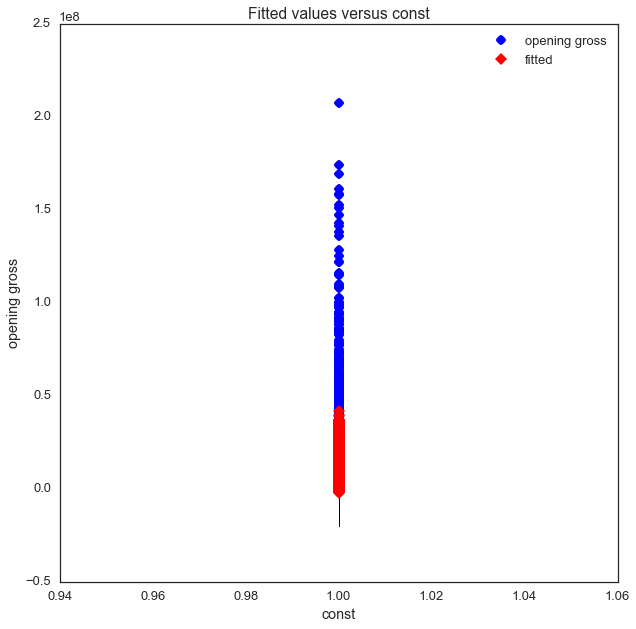

In [34]:
test_theaters = None
test_theaters = total_index_graph["opening theaters"].str.replace(",", "").convert_objects(convert_numeric=True)
test_theaters = sm.add_constant(test_theaters)
test_theaters["rating score"] = total_index_graph["rating score"]
test_theaters["implied body count score"] = total_index_graph["implied body count score"]
test_opening_gross = total_index_graph["opening gross"].str.replace("[,$]", "").convert_objects(convert_numeric=True)
print test_theaters.head(2)

results = sm.OLS(test_opening_gross,test_theaters, missing='drop').fit()

results.summary()
# plt.scatter(total_index_graph["body count score"], test_theaters)
# total_index_graph.dtypes
fig, ax = plt.subplots(figsize=(10,10))
fig = sm.graphics.plot_fit(results, 0, ax=ax)


In [35]:
###checkp
test_theaters = total_index_graph["opening theaters"].str.replace(",", "").convert_objects(convert_numeric=True)
test_theaters = other_sm.add_constant(test_theaters)
results = sm.OLS(total_index_graph["body count score"],test_theaters).fit()

no_nan_graph = total_index_graph.groupby('opening date').sum()
no_nan_graph = no_nan_graph['violence index'].dropna()
test_final_annoying_data = pd.DataFrame(no_nan_graph).join(v_crimes_per_day).dropna()
test_nan_X=test_final_annoying_data['violence index'].dropna()
test_nan_Y=test_final_annoying_data['Primary Type'].dropna()
test_results = sm.OLS( test_Y, est_X).fit()
test_results.summary()

NameError: name 'other_sm' is not defined

In [36]:
# v_movies_per_day

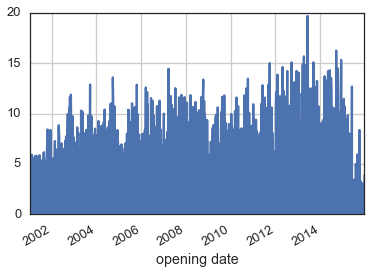

In [37]:
v_movies_per_day.plot(kind='area')

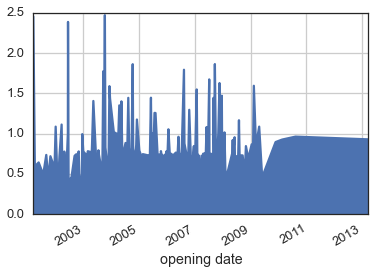

In [38]:
##graphs with nan values removed and not interpolated
no_nan_graph = total_index_graph.groupby('opening date').sum()
no_nan_graph = no_nan_graph['violence index'].dropna()
no_nan_graph.plot(kind='area')

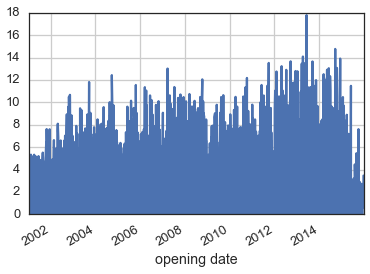

In [39]:
##graphs with nan values set to 1 and not interpolated
nan_1_graph = total_index_graph.groupby('opening date').sum()
nan_1_graph['body count score'] = nan_1_graph['body count score'].fillna(1)
nan_1_graph['normalized body count score'] =  nan_1_graph['body count score'].div(836)
nan_1_graph['violence index'] = nan_1_graph['normalized genre score'] + nan_1_graph['normalized rating score'] + nan_1_graph['normalized body count score']
nan_1_graph = nan_1_graph['violence index']
nan_1_graph.plot(kind='area')

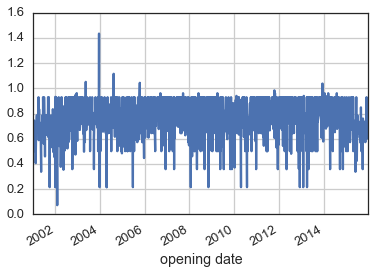

In [40]:
##original graph with the average violent movie rating for each day rather than the total violent movie rating per day
mean_graph = total_index_graph.groupby('opening date').mean()
mean_graph = mean_graph['implied violence index']
mean_graph.plot()

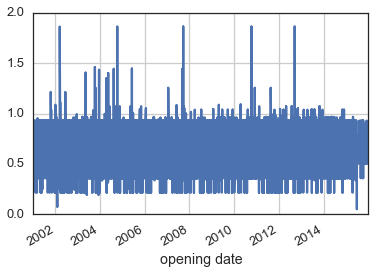

In [41]:
## each movie stands alone for each day alone rather than getting summed
stand_alone_graph = total_index_graph.copy()
stand_alone_graph = stand_alone_graph.set_index('opening date')
stand_alone_graph = stand_alone_graph['implied violence index']
stand_alone_graph.plot()

In [42]:
## each movie score extends out for seven days from the release date instead of just the opening date
import datetime
five_day_graph = total_index_graph.copy()
five_day_graph = five_day_graph.set_index(['title', 'opening date'])
new_rows = []
for row in five_day_graph.iterrows():
    for i in range(1,7):
        title , date = row[0]
        new_date = date + datetime.timedelta(days=i)
        new_row = five_day_graph.loc[(title, date)]
        new_row.name = (title, new_date)
        new_rows.append(new_row)
five_day_graph = five_day_graph.append(new_rows)
five_day_graph = five_day_graph.sort_index()


In [43]:
five_day_graph = five_day_graph.reset_index()
five_day_graph_no_nan = five_day_graph.copy()
# seven_day_graph = five_day_graph.copy()
three_day_graph = five_day_graph.copy()

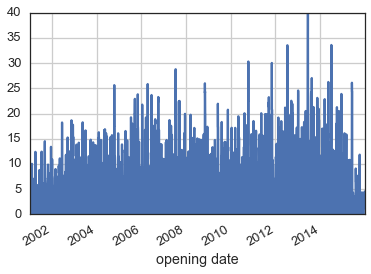

In [44]:
#7 day with interpolation
five_day_graph_i = five_day_graph.groupby('opening date').sum()
five_day_graph_i = five_day_graph_i['implied violence index']
five_day_graph_i.plot(kind='area')


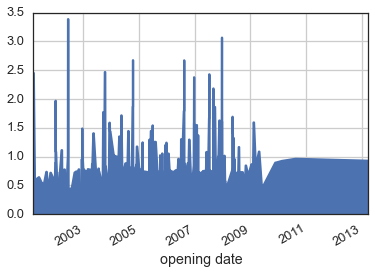

In [45]:
#7 day without interpolation
five_day_graph_no_nan = five_day_graph_no_nan.groupby('opening date').sum()
five_day_graph_no_nan = five_day_graph_no_nan['violence index'].dropna()
five_day_graph_no_nan.plot(kind='area')

In [46]:
# seven_day_graph

In [47]:
# seven_day_graph = seven_day_graph.reset_index()
# seven_day_graph_no_nan = seven_day_graph.copy()

In [48]:
# #7 day reducing with interpolation
# seven_day_graph_i = seven_day_graph.groupby('opening date').sum()
# seven_day_graph_i = seven_day_graph_i['reducing implied violence index']
# seven_day_graph_i.plot(kind='area')


In [49]:
# #7 day reducing without interpolation
# seven_day_graph_no_nan = seven_day_graph_no_nan.groupby('opening date').sum()
# seven_day_graph_no_nan = seven_day_graph_no_nan['reducing violence index'].dropna()
# seven_day_graph_no_nan.plot(kind='area')

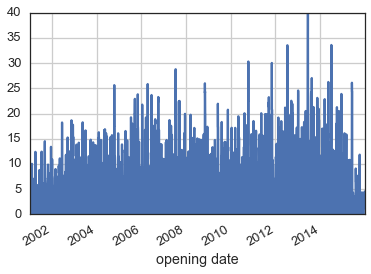

In [50]:
#7 day with interpolation
three_day_graph_i = three_day_graph.groupby('opening date').sum()
three_day_graph_i = three_day_graph_i['implied violence index']
three_day_graph_i.plot(kind='area')

In [51]:
## meaning of life graph
# mol_graph = total_index_graph.groupby('opening date')
# mol_graph = mol_graph['implied violence index']
# mol_graph.plot(figsize=(20,5))

In [52]:
# v_movies_per_day

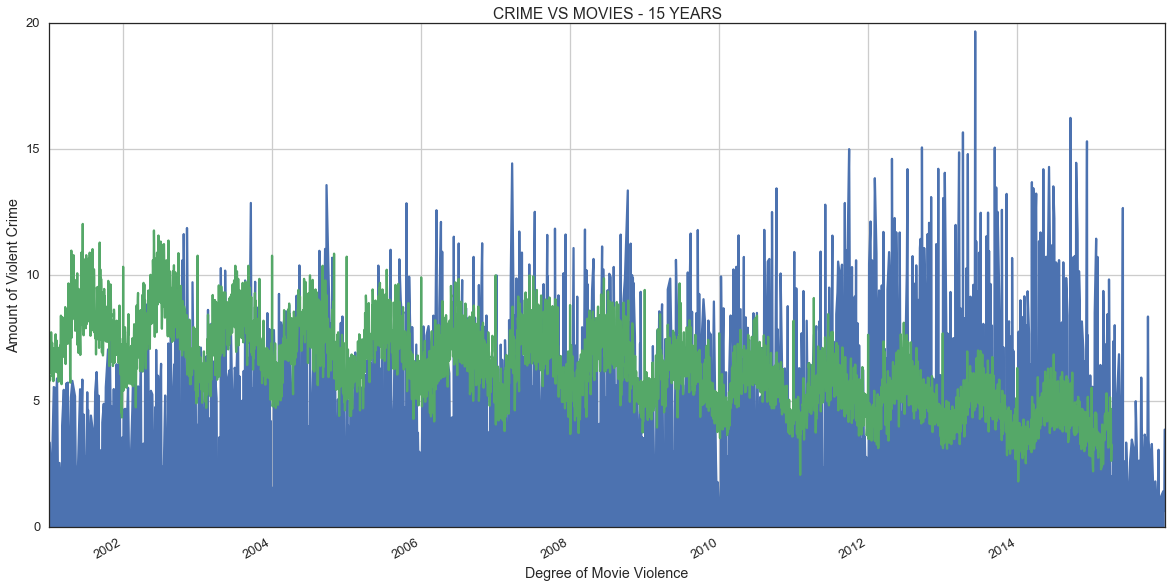

In [53]:
##original
ax = v_movies_per_day.plot(kind='area')
v_crimes_per_day.div(50).plot(figsize=(20,10), kind='line', title = "CRIME VS MOVIES - 15 YEARS", ax=ax)
ax.set_ylabel("Amount of Violent Crime")
ax.set_xlabel("Degree of Movie Violence")
plt.savefig('macro view')

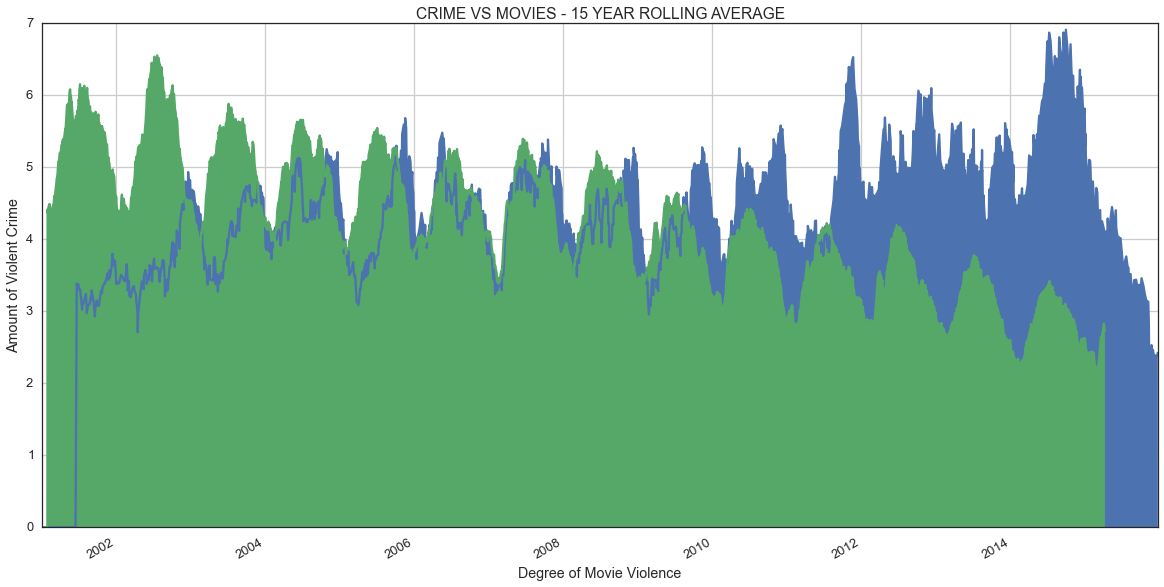

In [54]:
ax =pd.rolling_mean(v_movies_per_day, window=30).plot(kind='area')
pd.rolling_mean(v_crimes_per_day.div(75), window=30).plot(figsize=(20,10), kind='area', ax=ax, title='CRIME VS MOVIES - 15 YEAR ROLLING AVERAGE')
ax.set_ylabel("Amount of Violent Crime")
ax.set_xlabel("Degree of Movie Violence")
plt.savefig('mean macro level')

In [61]:
# stand_alone_g = total_index_graph.copy()
# stand_alone_g = stand_alone_g.set_index('opening date')
# stand_alone_g = stand_alone_g['implied violence index']
# pd.rolling_mean(stand_alone_g, window=75).plot(kind='area')
# pd.rolling_mean(v_crimes_per_day.div(500), window=75).plot(figsize=(20,5), kind='area')

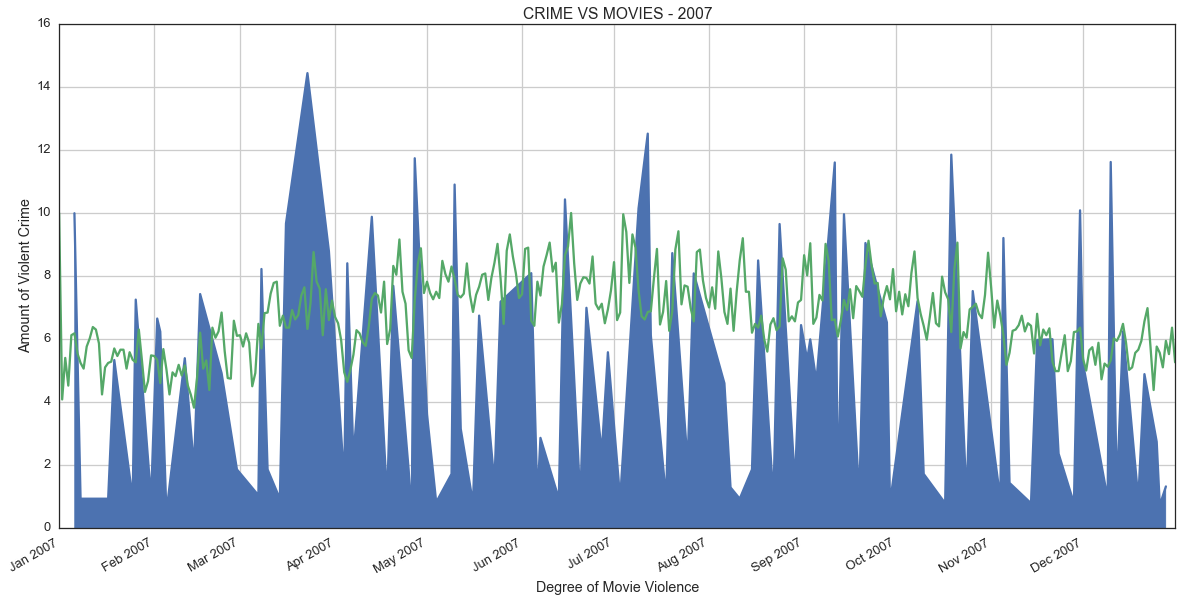

In [55]:
ax=v_movies_per_day['2007':'2007'].plot(kind='area')
v_crimes_per_day.div(50)['2007':'2007'].plot(figsize=(20,10), kind='line',ax=ax,title='CRIME VS MOVIES - 2007')
ax.set_ylabel("Amount of Violent Crime")
ax.set_xlabel("Degree of Movie Violence")
plt.savefig('2007 level')

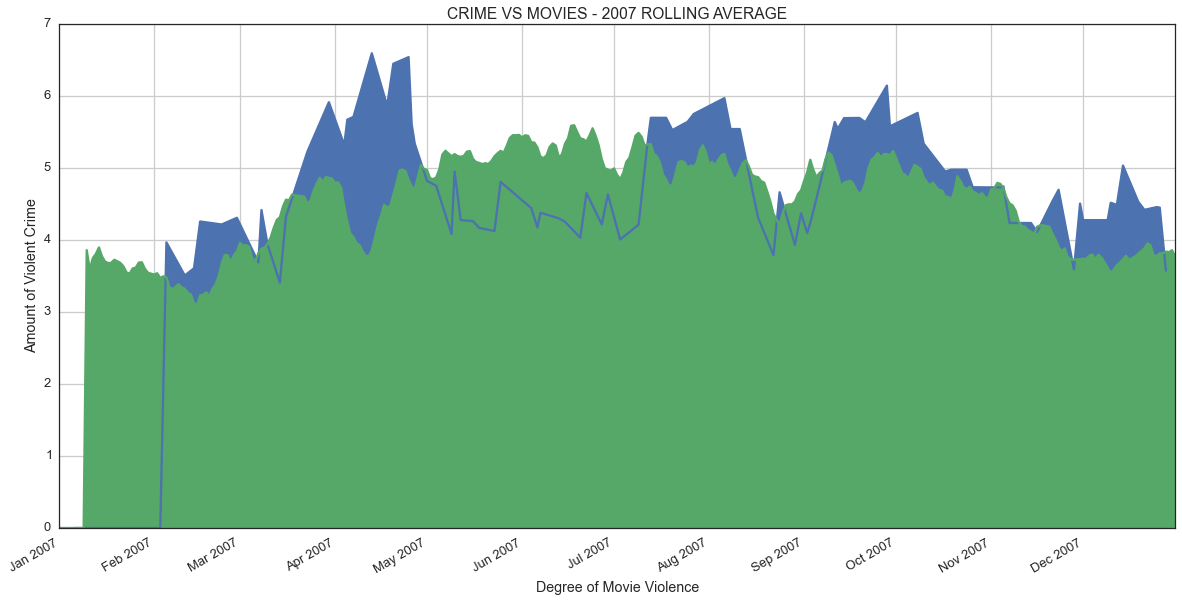

In [56]:
ax=pd.rolling_mean(v_movies_per_day['2007':'2007'], window=10).plot(kind='area')
pd.rolling_mean(v_crimes_per_day['2007':'2007'].div(75), window=10).plot(figsize=(20,10), kind='area', ax=ax,title='CRIME VS MOVIES - 2007 ROLLING AVERAGE')
ax.set_ylabel("Amount of Violent Crime")
ax.set_xlabel("Degree of Movie Violence")
plt.savefig('mean 2007 level')

In [64]:
# five_day_graph_no_nan

                            OLS Regression Results                            
Dep. Variable:           Primary Type   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3568
Date:                Thu, 23 Apr 2015   Prob (F-statistic):              0.550
Time:                        19:52:11   Log-Likelihood:                -6710.9
No. Observations:                1190   AIC:                         1.343e+04
Df Residuals:                    1188   BIC:                         1.344e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const            357.0577      4.216     84.

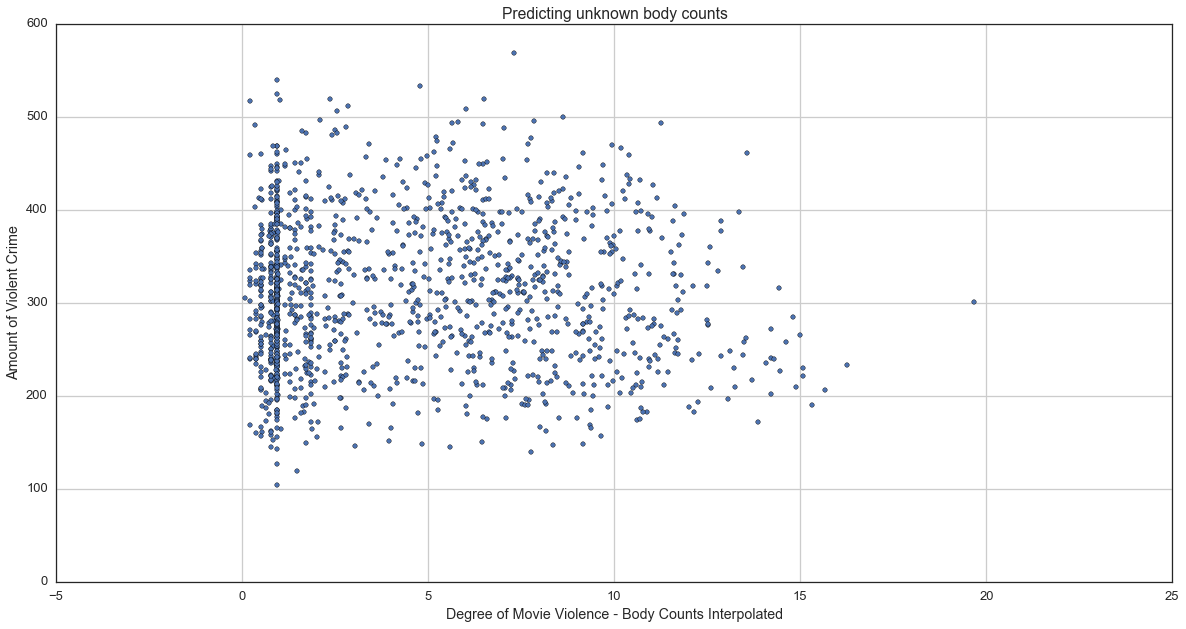

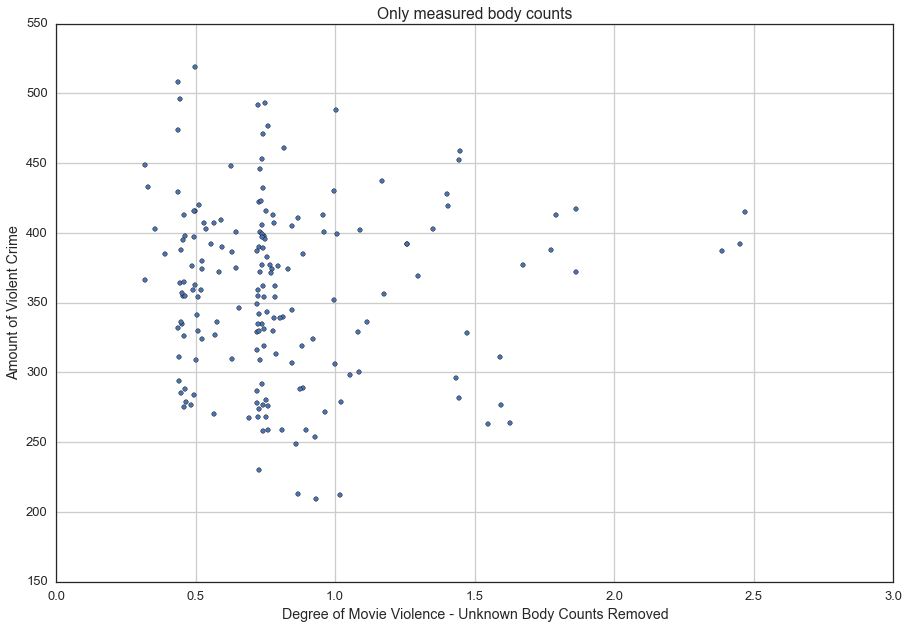

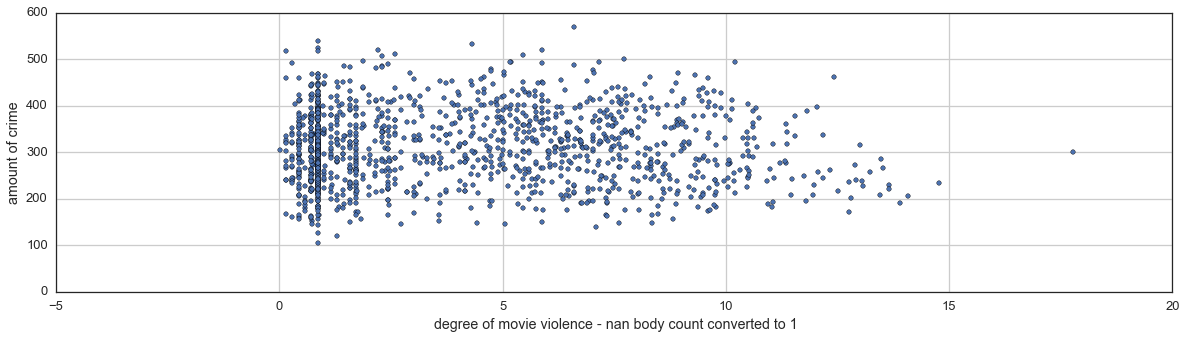

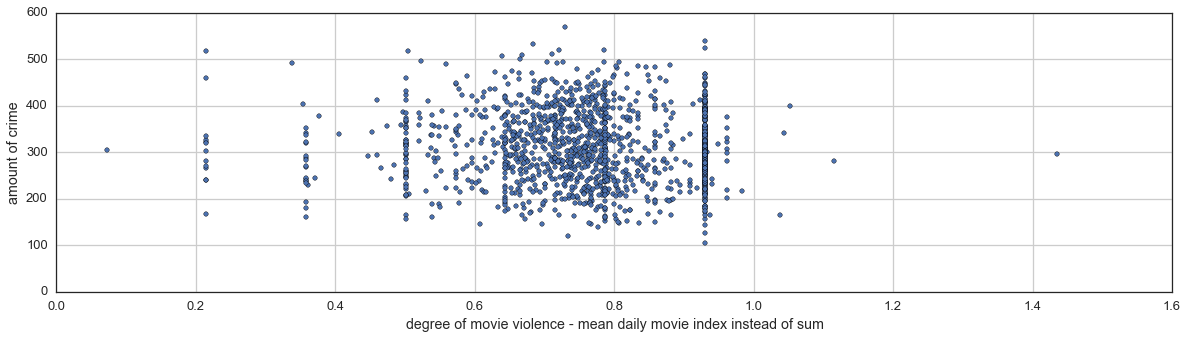

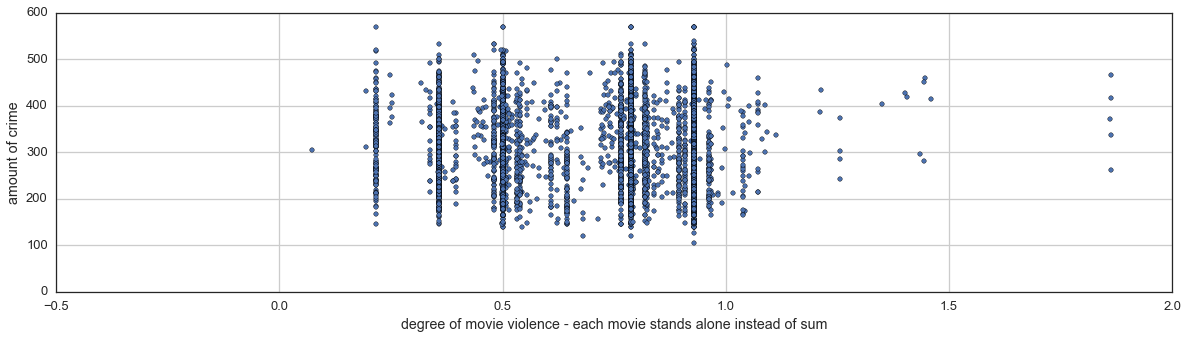

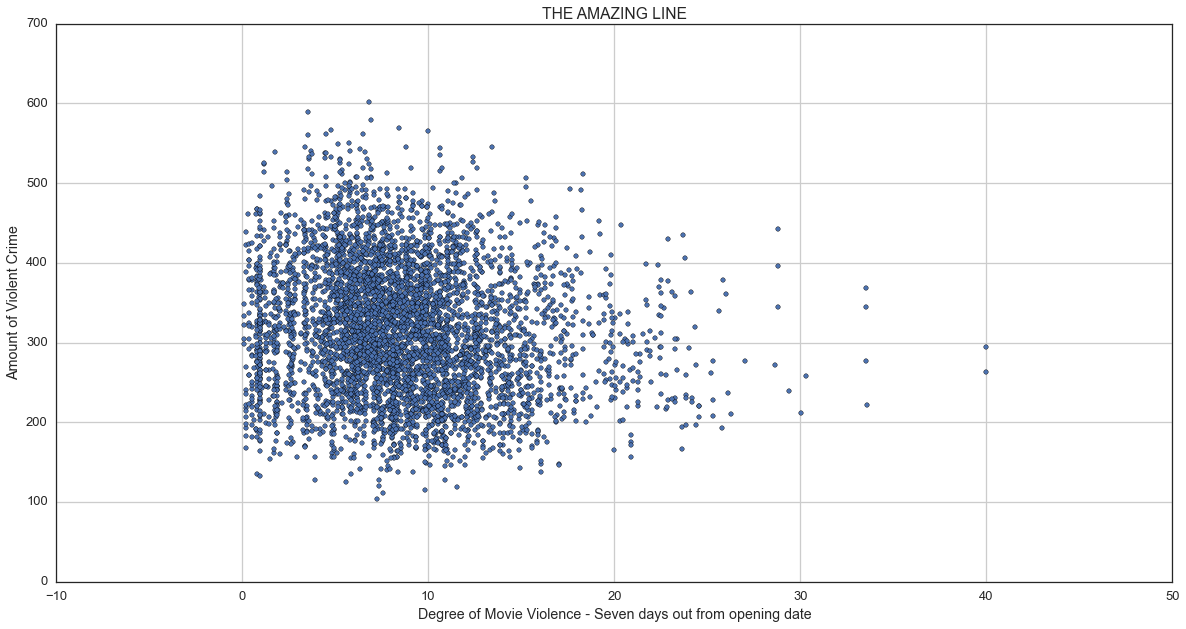

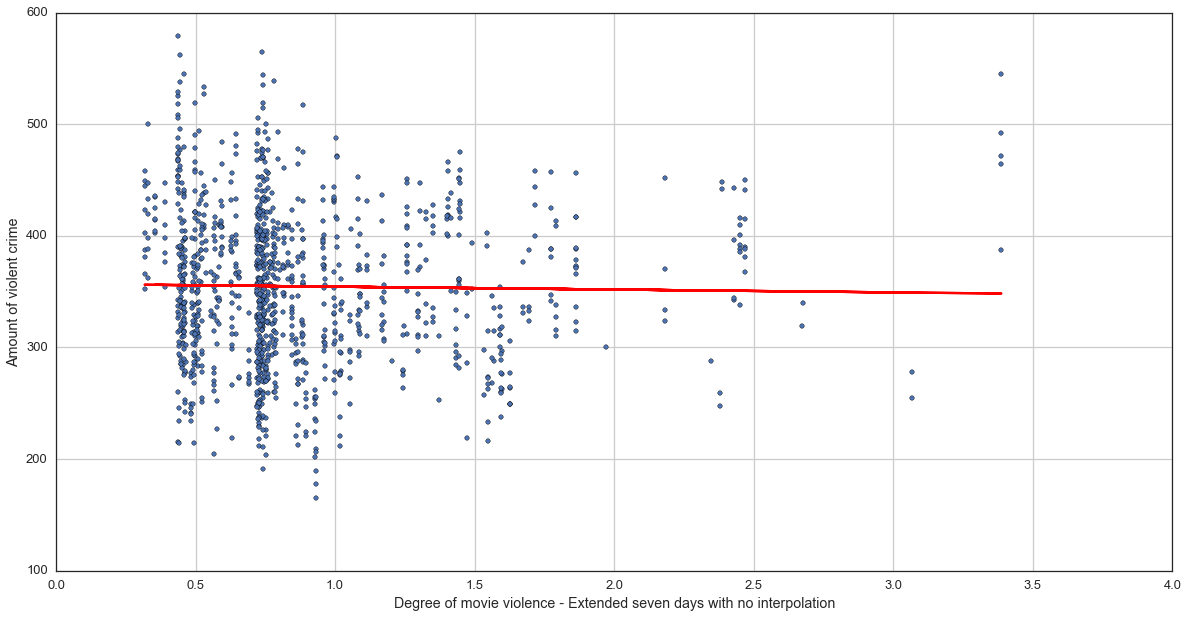

In [114]:

final_annoying_data = pd.DataFrame(v_movies_per_day).join(v_crimes_per_day).dropna()
ax = final_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,10),title="Predicting unknown body counts")
ax.set_ylabel("Amount of Violent Crime")
ax.set_xlabel("Degree of Movie Violence - Body Counts Interpolated")
plt.savefig('interpolated')


## nan body counts removed instead of interpolated
no_nan_final_annoying_data = pd.DataFrame(no_nan_graph).join(v_crimes_per_day).dropna()
no_nan_ax = no_nan_final_annoying_data.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(15,10), title="Only measured body counts")
no_nan_ax.set_ylabel("Amount of Violent Crime")
no_nan_ax.set_xlabel("Degree of Movie Violence - Unknown Body Counts Removed")
plt.savefig('uninterpolated')

## nan body counts converted to 1
nan_1_final_annoying_data = pd.DataFrame(nan_1_graph).join(v_crimes_per_day).dropna()
nan_1_ax = nan_1_final_annoying_data.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,5))
nan_1_ax.set_ylabel("amount of crime")
nan_1_ax.set_xlabel("degree of movie violence - nan body count converted to 1")

## mean graph for movies instead of sum of movie index per day
mean_annoying_data = pd.DataFrame(mean_graph).join(v_crimes_per_day).dropna()
mean_ax = mean_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
mean_ax.set_ylabel("amount of crime")
mean_ax.set_xlabel("degree of movie violence - mean daily movie index instead of sum")

## each movies stands alone instead of sum of movie index per day
stand_alone_annoying_data = pd.DataFrame(stand_alone_graph).join(v_crimes_per_day).dropna()
stand_alone_ax = stand_alone_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
stand_alone_ax.set_ylabel("amount of crime")
stand_alone_ax.set_xlabel("degree of movie violence - each movie stands alone instead of sum")

## each movie violence index extends out seven days with interpolation
five_day_data = pd.DataFrame(five_day_graph_i).join(v_crimes_per_day).dropna()
five_day_ax = five_day_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,10), title="THE AMAZING LINE")
five_day_ax.set_ylabel("Amount of Violent Crime")
five_day_ax.set_xlabel("Degree of Movie Violence - Seven days out from opening date")
plt.savefig('seven days out', bbox_inches ='tight')

## each movie violence index extends out seven days with nan values removed
five_day_data_no_nan = pd.DataFrame(five_day_graph_no_nan).join(v_crimes_per_day).dropna()
five_day_no_nan_ax = five_day_data_no_nan.plot(y='Primary Type', x="violence index", kind = "scatter", figsize=(20,10))
five_day_no_nan_ax.set_ylabel("Amount of violent crime")
five_day_no_nan_ax.set_xlabel("Degree of movie violence - Extended seven days with no interpolation")

five_day_data_no_nan2 = five_day_data_no_nan
five_day_data_no_nan2 = sm.add_constant(five_day_data_no_nan2)
model = sm.OLS(five_day_data_no_nan2["Primary Type"], five_day_data_no_nan2[['const','violence index']], missing='drop')
fitted = model.fit()
print fitted.summary()
plt.plot(five_day_data_no_nan2['violence index'], fitted.fittedvalues, 'r-')
plt.savefig("no interpolation best fit")

# ## each movie violence index extends out seven days with interpolation and reduces
# seven_day_data = pd.DataFrame(seven_day_graph_i).join(v_crimes_per_day).dropna()
# seven_day_ax = seven_day_data.plot(y='Primary Type', x="reducing implied violence index", kind = "scatter", figsize=(20,5))
# seven_day_ax.set_ylabel("amount of crime")
# seven_day_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/ interpolation and reducing")

# ## each movie violence index extends out seven days with nan values removed and reduces
# seven_day_data_no_nan = pd.DataFrame(seven_day_graph_no_nan).join(v_crimes_per_day).dropna()
# seven_day_no_nan_ax = seven_day_data_no_nan.plot(y='Primary Type', x="reducing violence index", kind='scatter',figsize=(20,5))
# seven_day_no_nan_ax.set_ylabel("amount of crime")
# seven_day_no_nan_ax.set_xlabel("degree of movie violence - each movie effect extends out 7 days w/out NaN and reducing")

## three day extension
# three_day_data_no_nan = pd.DataFrame(three_day_graph_i).join(v_crimes_per_day).dropna()
# three_day_no_nan_ax = three_day_data_no_nan.plot(y='Primary Type', x="implied violence index", kind='scatter',figsize=(20,5))
# three_day_no_nan_ax.set_ylabel("amount of crime")
# three_day_no_nan_ax.set_xlabel("degree of movie violence - each movie effect extends out 3 days w/ interpolation")



In [60]:
X=mean_annoying_data["implied violence index"]
Y=mean_annoying_data['Primary Type']
pearsonr(X, Y)

(-0.04010491380184425, 0.13761002138673029)

In [61]:
s = v_movies_per_day

#standard deviation for outliers
print  s.std()
#bool for those in the series exceeeding std dev
print s > s.std() * 3
#items which exceed std dev
print s[s > s.std() * 3]
#remove outliers from series
final_annoying_data.drop([s > s.std() * 3])

# s > s.std() * 3
# final_annoying_data = pd.DataFrame(v_movies_per_day).join(v_crimes_per_day).dropna()
# ax = final_annoying_data.plot(y='Primary Type', x="implied violence index", kind = "scatter", figsize=(20,5))
# ax.set_ylabel("amount of crime")
# ax.set_xlabel("degree of movie violence - nan body count interpolated")

3.77586147643
opening date
2001-01-06    False
2001-01-18    False
2001-01-19    False
2001-01-26    False
2001-02-02    False
2001-02-03    False
2001-02-11    False
2001-02-16    False
2001-02-23    False
2001-03-07    False
2001-03-08    False
2001-03-16    False
2001-03-23    False
2001-03-30    False
2001-04-03    False
2001-04-05    False
2001-04-07    False
2001-04-13    False
2001-04-20    False
2001-04-27    False
2001-05-10    False
2001-05-16    False
2001-05-18    False
2001-05-25    False
2001-06-04    False
2001-06-06    False
2001-06-07    False
2001-06-15    False
2001-06-16    False
2001-06-22    False
              ...  
2015-07-17    False
2015-07-24    False
2015-07-31    False
2015-08-04    False
2015-08-05    False
2015-08-14    False
2015-08-21    False
2015-08-28    False
2015-09-01    False
2015-09-09    False
2015-09-10    False
2015-09-18    False
2015-09-25    False
2015-09-30    False
2015-10-04    False
2015-10-07    False
2015-10-16    False
2015-10-23   

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [62]:
X=final_annoying_data['implied violence index']
Y=final_annoying_data['Primary Type']
X = sm.add_constant(X)

# final_annoying_data

In [63]:
results = sm.OLS( Y, X).fit()
results.summary()
# plt.scatter(X,Y)
# X_plot = np.linspace(0,1,100)
# plt.plot(X_plot, X_plot*results.params[0] + results.params[1])
# plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2875
Date:                Thu, 23 Apr 2015   Prob (F-statistic):              0.592
Time:                        18:45:54   Log-Likelihood:                -7946.1
No. Observations:                1372   AIC:                         1.590e+04
Df Residuals:                    1370   BIC:                         1.591e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                    312.2479      3.326     93.886      0.000       305.724   318.772
implied violence index    -0.3024      0.564     -0.536      0.592        -1.409     0.804
==============================================================================
Omnibus:                       28.317   Durbin-Watson:                   0.428
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.517
Skew:                           0.194   Prob(JB):                     3.51e-05
Kurtosis:                       2.543   Cond. No.                         9.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
## no nan body count
no_nan_X=no_nan_final_annoying_data['violence index'].dropna()
no_nan_Y=no_nan_final_annoying_data['Primary Type'].dropna()
no_nan_results = sm.OLS( no_nan_Y, no_nan_X).fit()
no_nan_results.summary()

# no_nan_results.fittedvalues.plot()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     687.3
Date:                Thu, 23 Apr 2015   Prob (F-statistic):           1.56e-63
Time:                        18:47:20   Log-Likelihood:                -1189.0
No. Observations:                 182   AIC:                             2380.
Df Residuals:                     181   BIC:                             2383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
violence index   360.8508     13.764     26.217      0.000       333.692   388.010
==============================================================================
Omnibus:                       39.610   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.008
Skew:                          -1.140   Prob(JB):                     1.26e-14
Kurtosis:                       4.801   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
# graphing_index.sort('body count score', ascending=False)

In [68]:
## nan body count set to 1
nan_1_X=nan_1_final_annoying_data['violence index'].dropna()
nan_1_Y=nan_1_final_annoying_data['Primary Type'].dropna()
nan_1_results = sm.OLS( nan_1_Y, nan_1_X).fit()
nan_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Primary Type   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     1653.
Date:                Thu, 23 Apr 2015   Prob (F-statistic):          1.02e-237
Time:                        18:47:10   Log-Likelihood:                -9321.9
No. Observations:                1372   AIC:                         1.865e+04
Df Residuals:                    1371   BIC:                         1.865e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
violence index    44.4636      1.094     40.652      0.000        42.318    46.609
==============================================================================
Omnibus:                       83.060   Durbin-Watson:                   1.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.786
Skew:                          -0.654   Prob(JB):                     5.84e-22
Kurtosis:                       2.975   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
graphing_index = full_index_graph.copy()

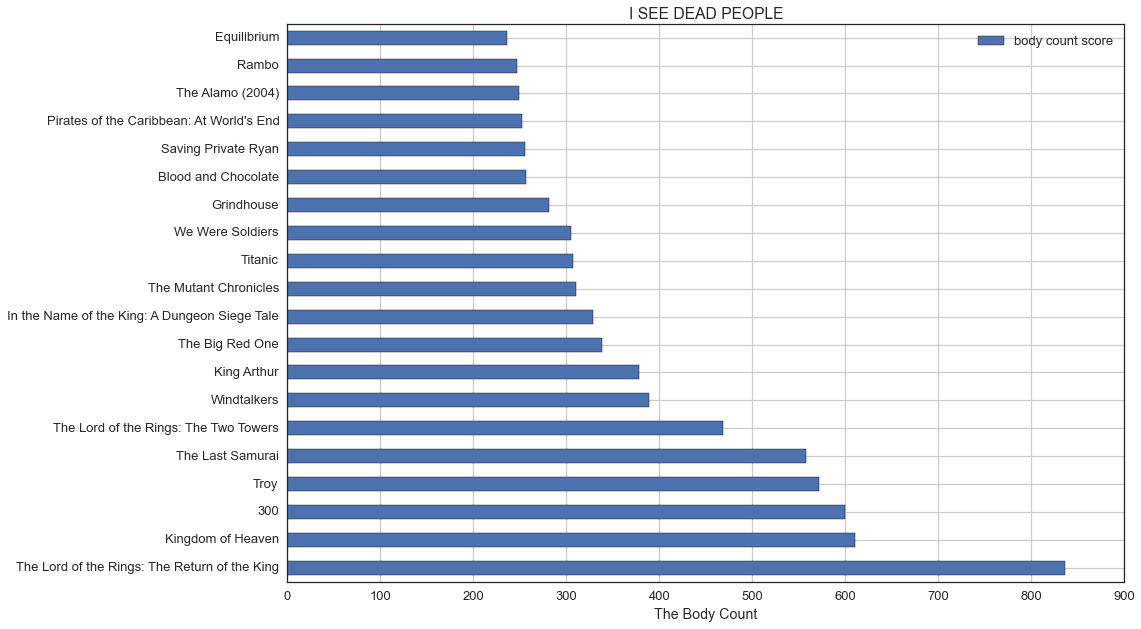

In [110]:

ax = graphing_index[['title', 'body count score']].sort('body count score', ascending=False)[0:20].plot(kind='barh', title='I SEE DEAD PEOPLE', figsize=(15,10))
ax.set_xlabel("The Body Count")
plt.savefig('body count', bbox_inches='tight')

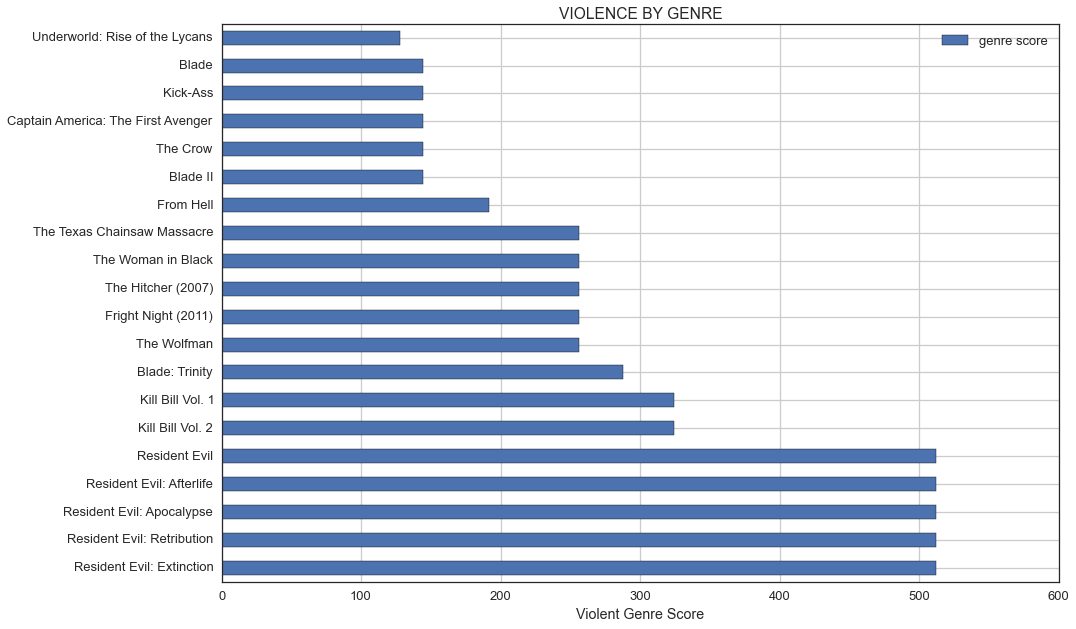

In [109]:

ax = graphing_index[['title', 'genre score']].sort('genre score', ascending=False)[0:20].plot(kind='barh', title='VIOLENCE BY GENRE', figsize=(15,10))
ax.set_xlabel("Violent Genre Score")
plt.savefig('genre score', bbox_inches='tight')

                            OLS Regression Results                            
Dep. Variable:           Primary Type   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     90.44
Date:                Thu, 23 Apr 2015   Prob (F-statistic):           2.88e-21
Time:                        18:48:09   Log-Likelihood:                -28859.
No. Observations:                4968   AIC:                         5.772e+04
Df Residuals:                    4966   BIC:                         5.774e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                    335

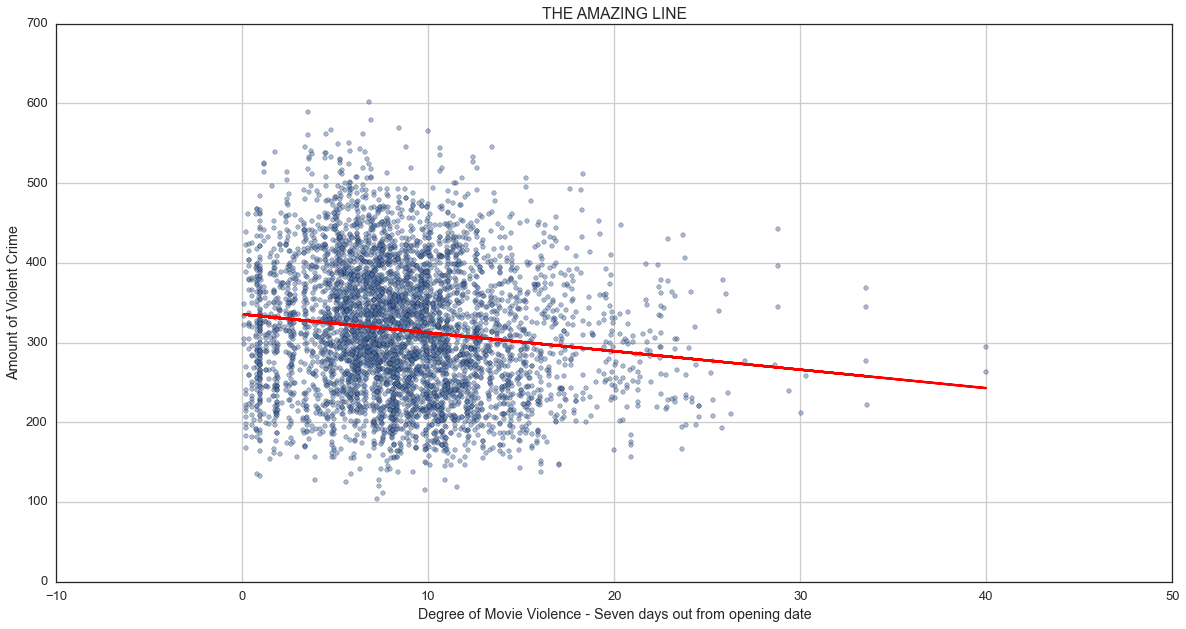

In [79]:



## each movie violence index extends out seven days with interpolation
five_day_data_2 = pd.DataFrame(five_day_graph_i).join(v_crimes_per_day).dropna()
five_day_data_2 = sm.add_constant(five_day_data_2)
five_day_ax = five_day_data_2.plot(y='Primary Type', x="implied violence index", alpha=0.5,kind = "scatter", figsize=(20,10), title="THE AMAZING LINE")
five_day_ax.set_ylabel("Amount of Violent Crime")
five_day_ax.set_xlabel("Degree of Movie Violence - Seven days out from opening date")

model = sm.OLS(five_day_data_2["Primary Type"], five_day_data_2[['const','implied violence index']], missing='drop')
fitted = model.fit()
print fitted.summary()

plt.plot(five_day_data_2['implied violence index'], fitted.fittedvalues, 'r-')
plt.savefig('best_fit_crime_rate', bbox_inches ='tight')

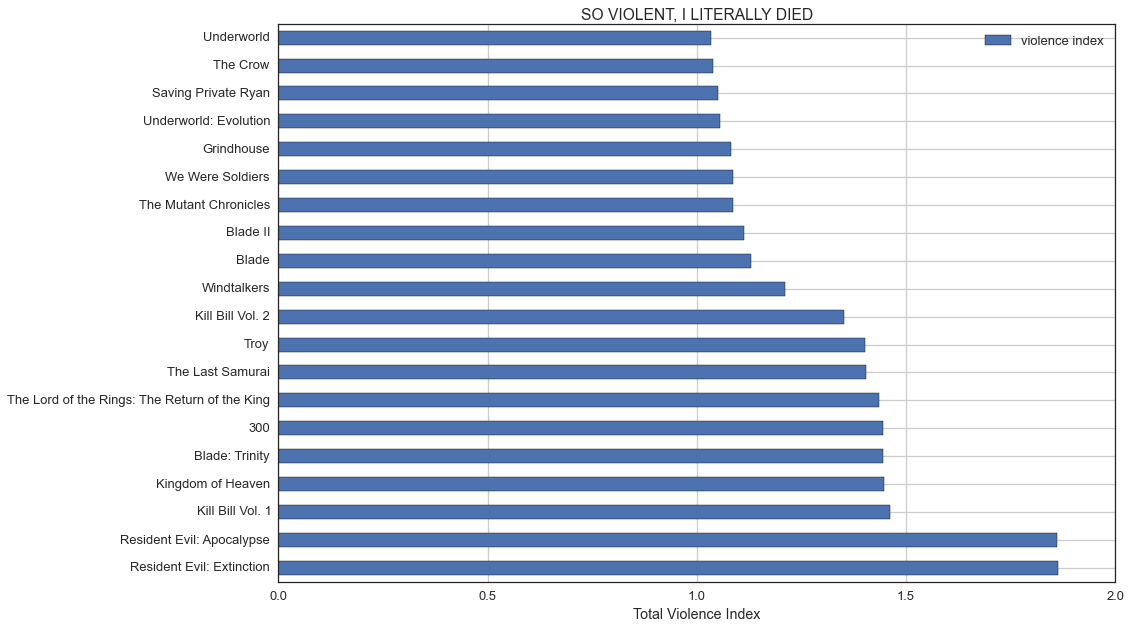

In [111]:

ax = graphing_index[['title', 'violence index']].sort('violence index', ascending=False)[0:20].plot(kind='barh',figsize=(15,10), title='SO VIOLENT, I LITERALLY DIED')

ax.set_xlabel("Total Violence Index")
plt.savefig('violence index', bbox_inches='tight')

In [84]:
full_index_graph = sm.add_constant(full_index_graph)
full_index_graph.dtypes

# v_crimes_per_day.head()

const                                           int64
title                                          object
runtime                                        object
rating                                         object
studio                                         object
opening date                           datetime64[ns]
opening gross                                  object
opening theaters                               object
total gross                                    object
total theaters                                 object
boxofficemojo url                              object
genre score                                   float64
normalized genre score                        float64
rating score                                    int64
normalized rating score                       float64
body count score                              float64
normalized body count score                   float64
violence index                                float64
implied body count score    

In [85]:
full_index_graph['total gross'] = full_index_graph["total gross"].str.replace(",", "").str.replace('$','').convert_objects(convert_numeric=True)

In [86]:
full_index_graph['total theaters'] = full_index_graph["total theaters"].str.replace(",", "").convert_objects(convert_numeric=True)

In [87]:
full_index_graph['opening theaters'] = full_index_graph["opening theaters"].str.replace(",", "").convert_objects(convert_numeric=True)

                            OLS Regression Results                            
Dep. Variable:            total gross   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     76.40
Date:                Thu, 23 Apr 2015   Prob (F-statistic):           1.12e-45
Time:                        20:42:46   Log-Likelihood:                -6351.8
No. Observations:                 332   AIC:                         1.271e+04
Df Residuals:                     327   BIC:                         1.273e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const             2.422e+07   1.71e+07  

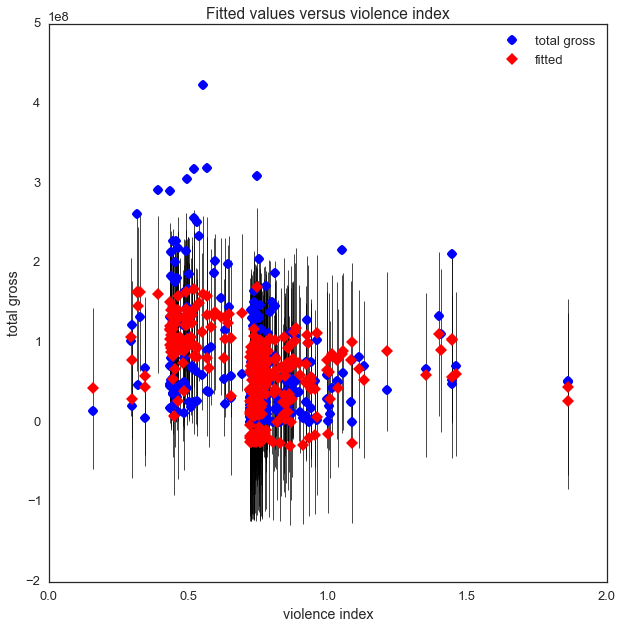

In [122]:
###number of bodies compared to genre, rating

model = sm.OLS(full_index_graph["total gross"], full_index_graph[['const', 'violence index', 'body count score','rating score', 'genre score', 'total theaters']], missing='drop')
fitted = model.fit()
print fitted.summary()
print len(fitted.fittedvalues)
print len(full_index_graph['implied violence index'])
fig, ax = plt.subplots(figsize=(10,10))
fig = sm.graphics.plot_fit(fitted, 1, ax=ax)
# plt.plot(full_index_graph['implied violence index'], fitted.fittedvalues, 'ro')
# plt.savefig('best_fit_crime_rate.pdf', bbox_inches ='tight')

TypeError: invalid type promotion

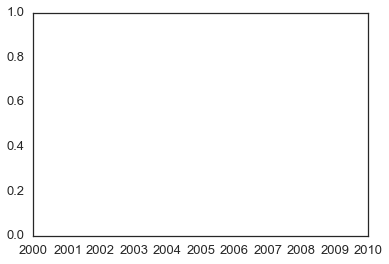

In [89]:

plt.scatter(full_index_graph['opening date'], full_index_graph['total gross'])

ValueError: x and y must have same first dimension

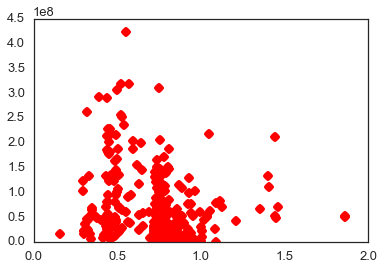

In [90]:
plt.plot(full_index_graph['violence index'], full_index_graph['total gross'], 'ro')
plt.plot(full_index_graph['violence index'], fitted.fittedvalues, 'b')

In [91]:
df2 = full_index_graph

sns.lmplot("violence index", "total gross", data=df2,
           col_wrap=2, ci=None, palette="muted", size=4,
           scatter_kws={"s": 50, "alpha": 1})

ValueError: cannot label index with a null key

In [92]:
full_index_graph[:10]


,const,title,runtime,rating,studio,opening date,opening gross,opening theaters,total gross,total theaters,...,normalized genre score,rating score,normalized rating score,body count score,normalized body count score,violence index,implied body count score,normalized implied body count score,implied violence index,violence rank
$9.99,1,$9.99,1 hrs. 18 min.,R,Reg.,2008-12-12,$478,1,52384,4,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
$upercapitalist,1,$upercapitalist,1 hrs. 36 min.,Unrated,Truly,2012-10-08,"$8,372",1,15919,1,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5
'71,1,'71,1 hrs. 39 min.,R,RAtt.,2015-02-27,"$55,761",4,1223516,121,...,0.007812,5,0.714286,NaN,NaN,NaN,80.533333,0.096332,0.818430,5015.5
'N Sync: Bigger Than Live (IMAX),1,'N Sync: Bigger Than Live (IMAX),0 hrs. 47 min.,Unrated,Imax,2001-02-02,"$44,082",10,1808679,20,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5
'Neath the Arizona Skies,1,'Neath the Arizona Skies,0 hrs. 52 min.,Unrated,Monog.,1934-05-12,n/a,NaN,NaN,NaN,...,0.003906,6,0.857143,NaN,NaN,NaN,39.973684,0.047815,0.908865,4249.5
"'Night, Mother",1,"'Night, Mother",1 hrs. 36 min.,PG-13,Uni.,1986-12-09,"$49,164",3,441863,35,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0
'R Xmas,1,'R Xmas,1 hrs. 23 min.,R,Path.,2002-08-11,$850,1,850,1,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
'Round Midnight,1,'Round Midnight,2 hrs. 13 min.,R,WB,1986-03-10,"$25,384",1,3272593,50,...,0.001953,5,0.714286,NaN,NaN,NaN,58.946809,0.070511,0.786749,7209.0
'Tis Autumn: The Search for Jackie Paris,1,'Tis Autumn: The Search for Jackie Paris,1 hrs. 40 min.,Unrated,OutF,2007-07-12,"$1,476",1,1476,1,...,0.001953,6,0.857143,NaN,NaN,NaN,58.946809,0.070511,0.929607,2216.5
(500) Days of Summer,1,(500) Days of Summer,1 hrs. 35 min.,PG-13,FoxS,2009-07-17,"$834,501",27,32391374,1048,...,0.001953,3,0.428571,NaN,NaN,NaN,58.946809,0.070511,0.501035,11664.0


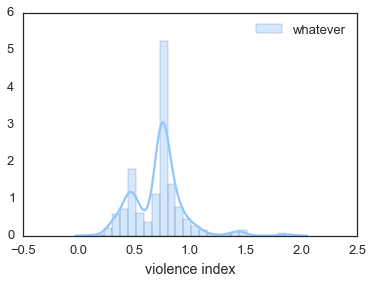

In [93]:
sns.set_palette("pastel")
# mpl.rc("figure", figsize=(8, 4))
all_label = "whatever"
sns.distplot(full_index_graph['violence index'].dropna(), label=all_label);
plt.legend()

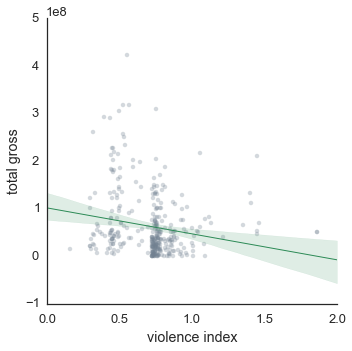

In [94]:
sns.lmplot("violence index", "total gross", full_index_graph, ci=95,
           scatter_kws={"color": "slategray", "alpha": .3},
           line_kws={"linewidth": 1, "color": "seagreen"})